In [7]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
! pip install --upgrade pandas yaml tensorflow tensorflow-probability ml-collections jraph

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 276.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 369.8 MB/s eta 0:00:00


In [1]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

## Dirs

In [2]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## Carol's runs
# logging_dir = "/n/holyscratch01/iaifi_lab/ccuesta/checkpoints/"

# run_name = "blooming-puddle-230"  # Has weird likelihoods
# run_name = "chocolate-cloud-122"  # The one in the paper
# run_name = "silver-breeze-231"  # Only rotations
# run_name = "hopeful-bush-231"  # Only translations

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/cosmology-augmentations/"
# run_name = "efficient-firefly-111"  # No translations or rotations
run_name = "worldly-voice-112"  # Only translations
run_name = "stilted-oath-118" # Both; longer run

## Load cluster run

In [3]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [4]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        config.training.batch_size,
        config.seed,
        shuffle=True,
        split="test",
        #**config.data.kwargs,
    )

batches = create_input_iter(train_ds)

In [5]:
config.data

add_augmentations: true
add_rotations: true
add_translations: true
box_size: 1000.0
dataset: nbody
kwargs: {}
n_features: 3
n_particles: 5000
n_pos_features: 3

In [6]:
x, conditioning, mask = next(batches)
x = x[0]
conditioning = conditioning[0]
mask = mask[0]

In [7]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [8]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
    d_feature=config.data.n_features,
    timesteps=config.vdm.timesteps,
    noise_schedule=config.vdm.noise_schedule,
    noise_scale=config.vdm.noise_scale,
    gamma_min=config.vdm.gamma_min,
    gamma_max=config.vdm.gamma_max,
    score=config.score.score,
    score_dict=score_dict,
    embed_context=config.vdm.embed_context,
    d_context_embedding=config.vdm.d_context_embedding,
    n_classes=config.vdm.n_classes,
    use_encdec=config.vdm.use_encdec,
    encoder_dict=encoder_dict,
    decoder_dict=decoder_dict,
    norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 268,707


In [9]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [10]:
n_samples = 2
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()

Text(0.5, 0, 'z')

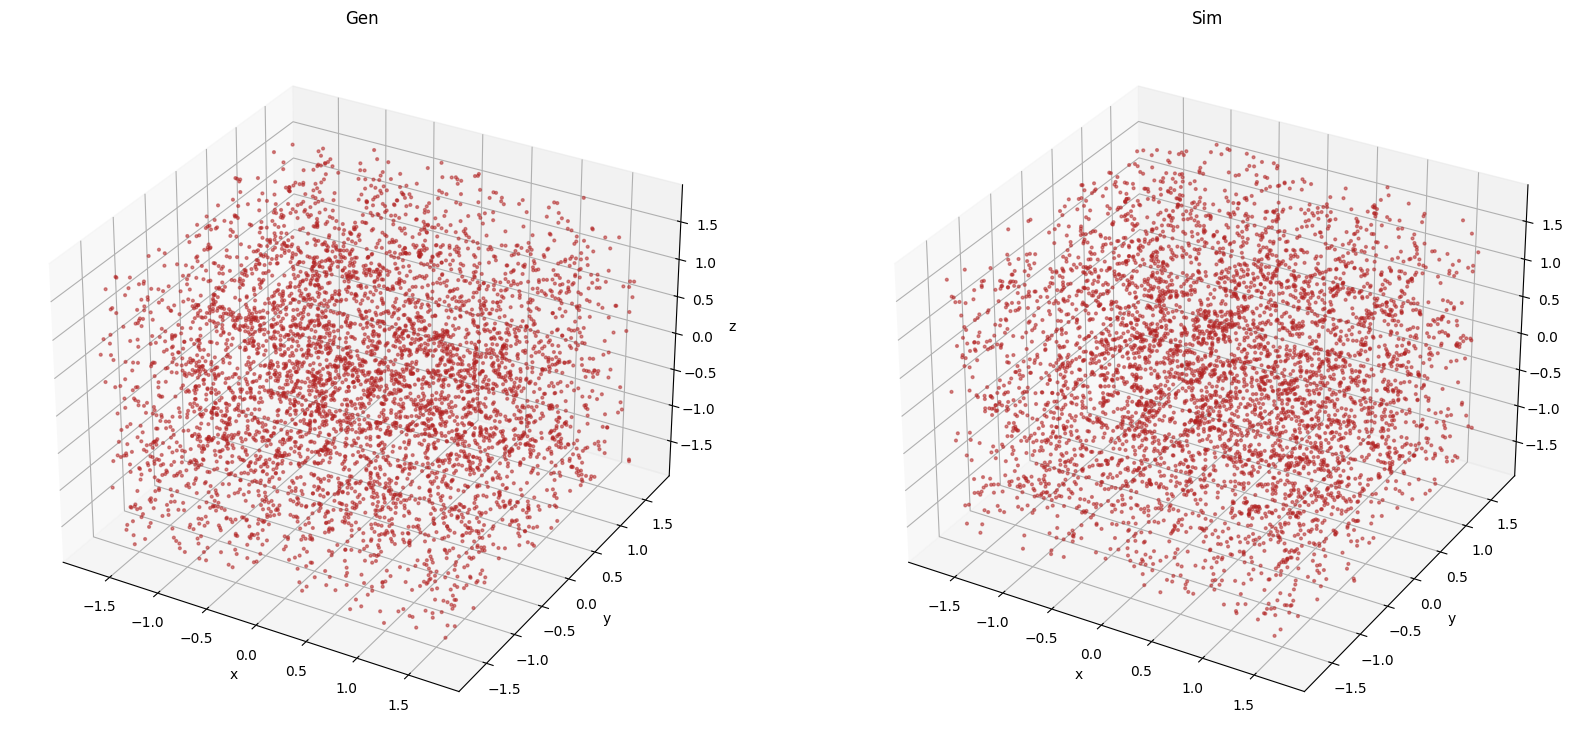

In [11]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

## Likelihood eval

In [12]:
from functools import partial

In [50]:
def elbo(vdm, params, rng, x, conditioning, mask, steps=20, unroll_loop=True):
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = vdm.apply(params, x, conditioning, method=vdm.encode)
    loss_recon = vdm.apply(params, x, f, conditioning, rngs={"sample": rng}, method=vdm.recon_loss)
    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)
    
    if not unroll_loop:
        
        def body_fun(i, val):
            loss, rng = val
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]), f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            return (loss + (new_loss * mask[..., None]).sum((-1, -2)) / steps, rng)

        loss_diff, rng = jax.lax.fori_loop(0, steps, body_fun, (np.zeros(x.shape[0]), rng))

    else:
        
        loss_diff, rng = (np.zeros(x.shape[0]), rng)

        for i in range(steps):
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]), f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            loss_diff =  loss_diff + (new_loss * mask[..., None]).sum((-1, -2)) / steps

    return ((loss_recon * mask[..., None]).sum((-1, -2)) + (loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)


In [51]:
@jax.jit
def likelihood(theta_test, x_test, n_samples=2):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, restored_state.params, rng, x_test, theta_test, np.ones_like(x_test[..., 0])).mean()

In [52]:
# idx = 421
idx = 4

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

theta_test = np.array([Omega_m, sigma_8])
likelihood(theta_test, x_test)

Array(-21989.598, dtype=float32)

In [53]:
sigma_8_ary = np.linspace(0.6, 1.0, 30)

log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(theta_test, x_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.41s/it]


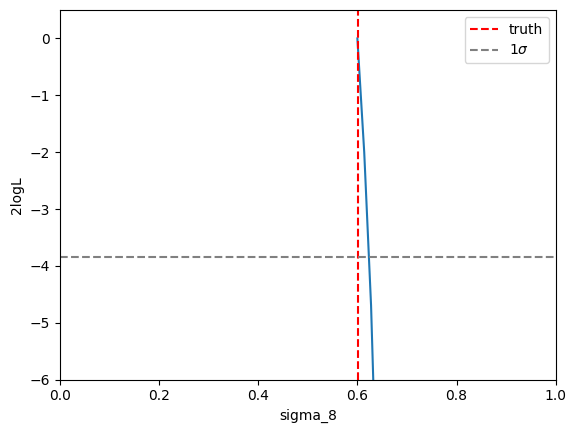

In [54]:
from scipy.stats import chi2

plt.plot(sigma_8_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"sigma_8")

plt.legend()

In [55]:
omega_m_ary = np.linspace(0.1, 0.5, 30)

log_like = []

for omega_m in tqdm(omega_m_ary):
    theta_test = np.array([omega_m, conditioning[idx][1]])
    log_like.append(likelihood(theta_test, x_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.41s/it]


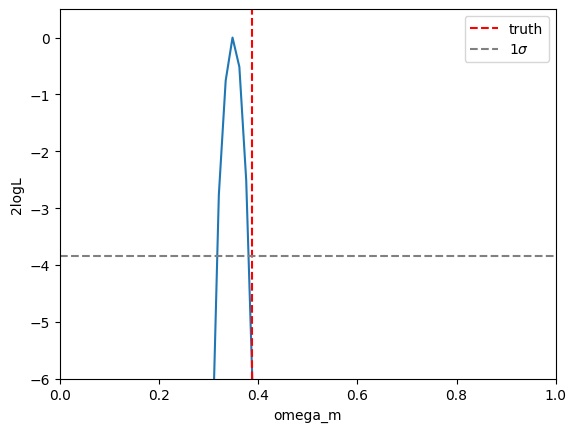

In [56]:
from scipy.stats import chi2

plt.plot(omega_m_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][0], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()